In [1]:
import json
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from meteostat import Hourly

In [2]:
%load_ext blackcellmagic

In [3]:
def wgs84_to_lv95(ϕ, λ):
    ϕ = (ϕ * 3600 - 169028.66) / 10000
    λ = (λ * 3600 - 26782.5) / 10000
    N = (
        1200147.07
        + 308807.95 * ϕ
        + 3745.25 * (λ ** 2)
        + 76.63 * (ϕ ** 2)
        - 194.56 * (λ ** 2) * ϕ
        + 119.79 * (ϕ ** 3)
    )
    E = (
        2600072.37
        + 211455.93 * λ
        - 10938.51 * λ * ϕ
        - 0.36 * λ * (ϕ ** 2)
        - 44.54 * (λ ** 3)
    )
    return E, N

In [4]:
# tracks = []
# for path in Path("data/polar-user-data-export/").glob("training-session*.json"):
#     with open(path, "r") as file:
#         data = json.load(file)
#         if data["name"] != "Cycling" or data["startTime"] < "2024-06-25":
#             continue

#         track = pd.DataFrame(data["exercises"][0]["samples"]["heartRate"]).rename(
#             columns={"dateTime": "Time", "value": "Heart rate"}
#         )
#         track["Time"] = pd.to_datetime(track["Time"])

#         wgs84 = pd.DataFrame(
#             data["exercises"][0]["samples"]["recordedRoute"]
#         ).set_index("dateTime")
#         lv95 = pd.DataFrame(
#             wgs84_to_lv95(wgs84["latitude"], wgs84["longitude"]),
#             index=["E", "N"],
#         ).T
#         for location, (E_i, N_i), (E_f, N_f) in [
#             # ("initial climb", (2_600_204.98, 1_198_126.11), (2_600_548.43, 1_197_848.51)),
#             ("flat stretch", (2_602_461.80, 1_197_050.09), (2_601_283.60, 1_198_064.83)),
#             ("downhill", (2_600_987.10, 1_197_839.70), (2_600_455.48, 1_198_090.90)),
#         ]:
#             start = pd.to_datetime(lv95.eval("(E - @E_i)**2 + (N - @N_i)**2").idxmin())
#             end = pd.to_datetime(lv95.eval("(E - @E_f)**2 + (N - @N_f)**2").idxmin())
#             track.loc[track.eval("@start <= Time <= @end"), "location"] = location

#         tracks.append(track)

# tracks = pd.concat(tracks)
# tracks.to_csv("data/cycling.csv.gz", index=False)

tracks = pd.read_csv("data/cycling.csv.gz", parse_dates=["Time"])
tracks.head()

,Time,Heart rate,location
0,2024-06-27 09:21:34,91.0,NaN
1,2024-06-27 09:21:35,91.0,NaN
2,2024-06-27 09:21:36,90.0,NaN
3,2024-06-27 09:21:37,88.0,NaN
4,2024-06-27 09:21:38,87.0,NaN


In [5]:
# LSZB0 is the Airport Bern-Belp, fairly close to the flat stretch.
weather = Hourly("LSZB0", start=tracks["Time"].min(), end=tracks["Time"].max()).fetch()
weather.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-06-27 10:00:00,24.0,17.0,65.0,0.2,NaN,150.0,5.4,NaN,1014.0,NaN,17.0
2024-06-27 11:00:00,26.0,17.9,61.0,0.1,NaN,260.0,7.6,NaN,1014.0,NaN,17.0
2024-06-27 12:00:00,27.0,15.1,48.0,0.4,NaN,260.0,14.8,NaN,1014.0,NaN,17.0
2024-06-27 13:00:00,28.0,15.0,45.0,0.1,NaN,300.0,11.2,NaN,1014.0,NaN,17.0
2024-06-27 14:00:00,29.0,12.8,37.0,0.0,NaN,280.0,18.4,NaN,1014.0,NaN,2.0


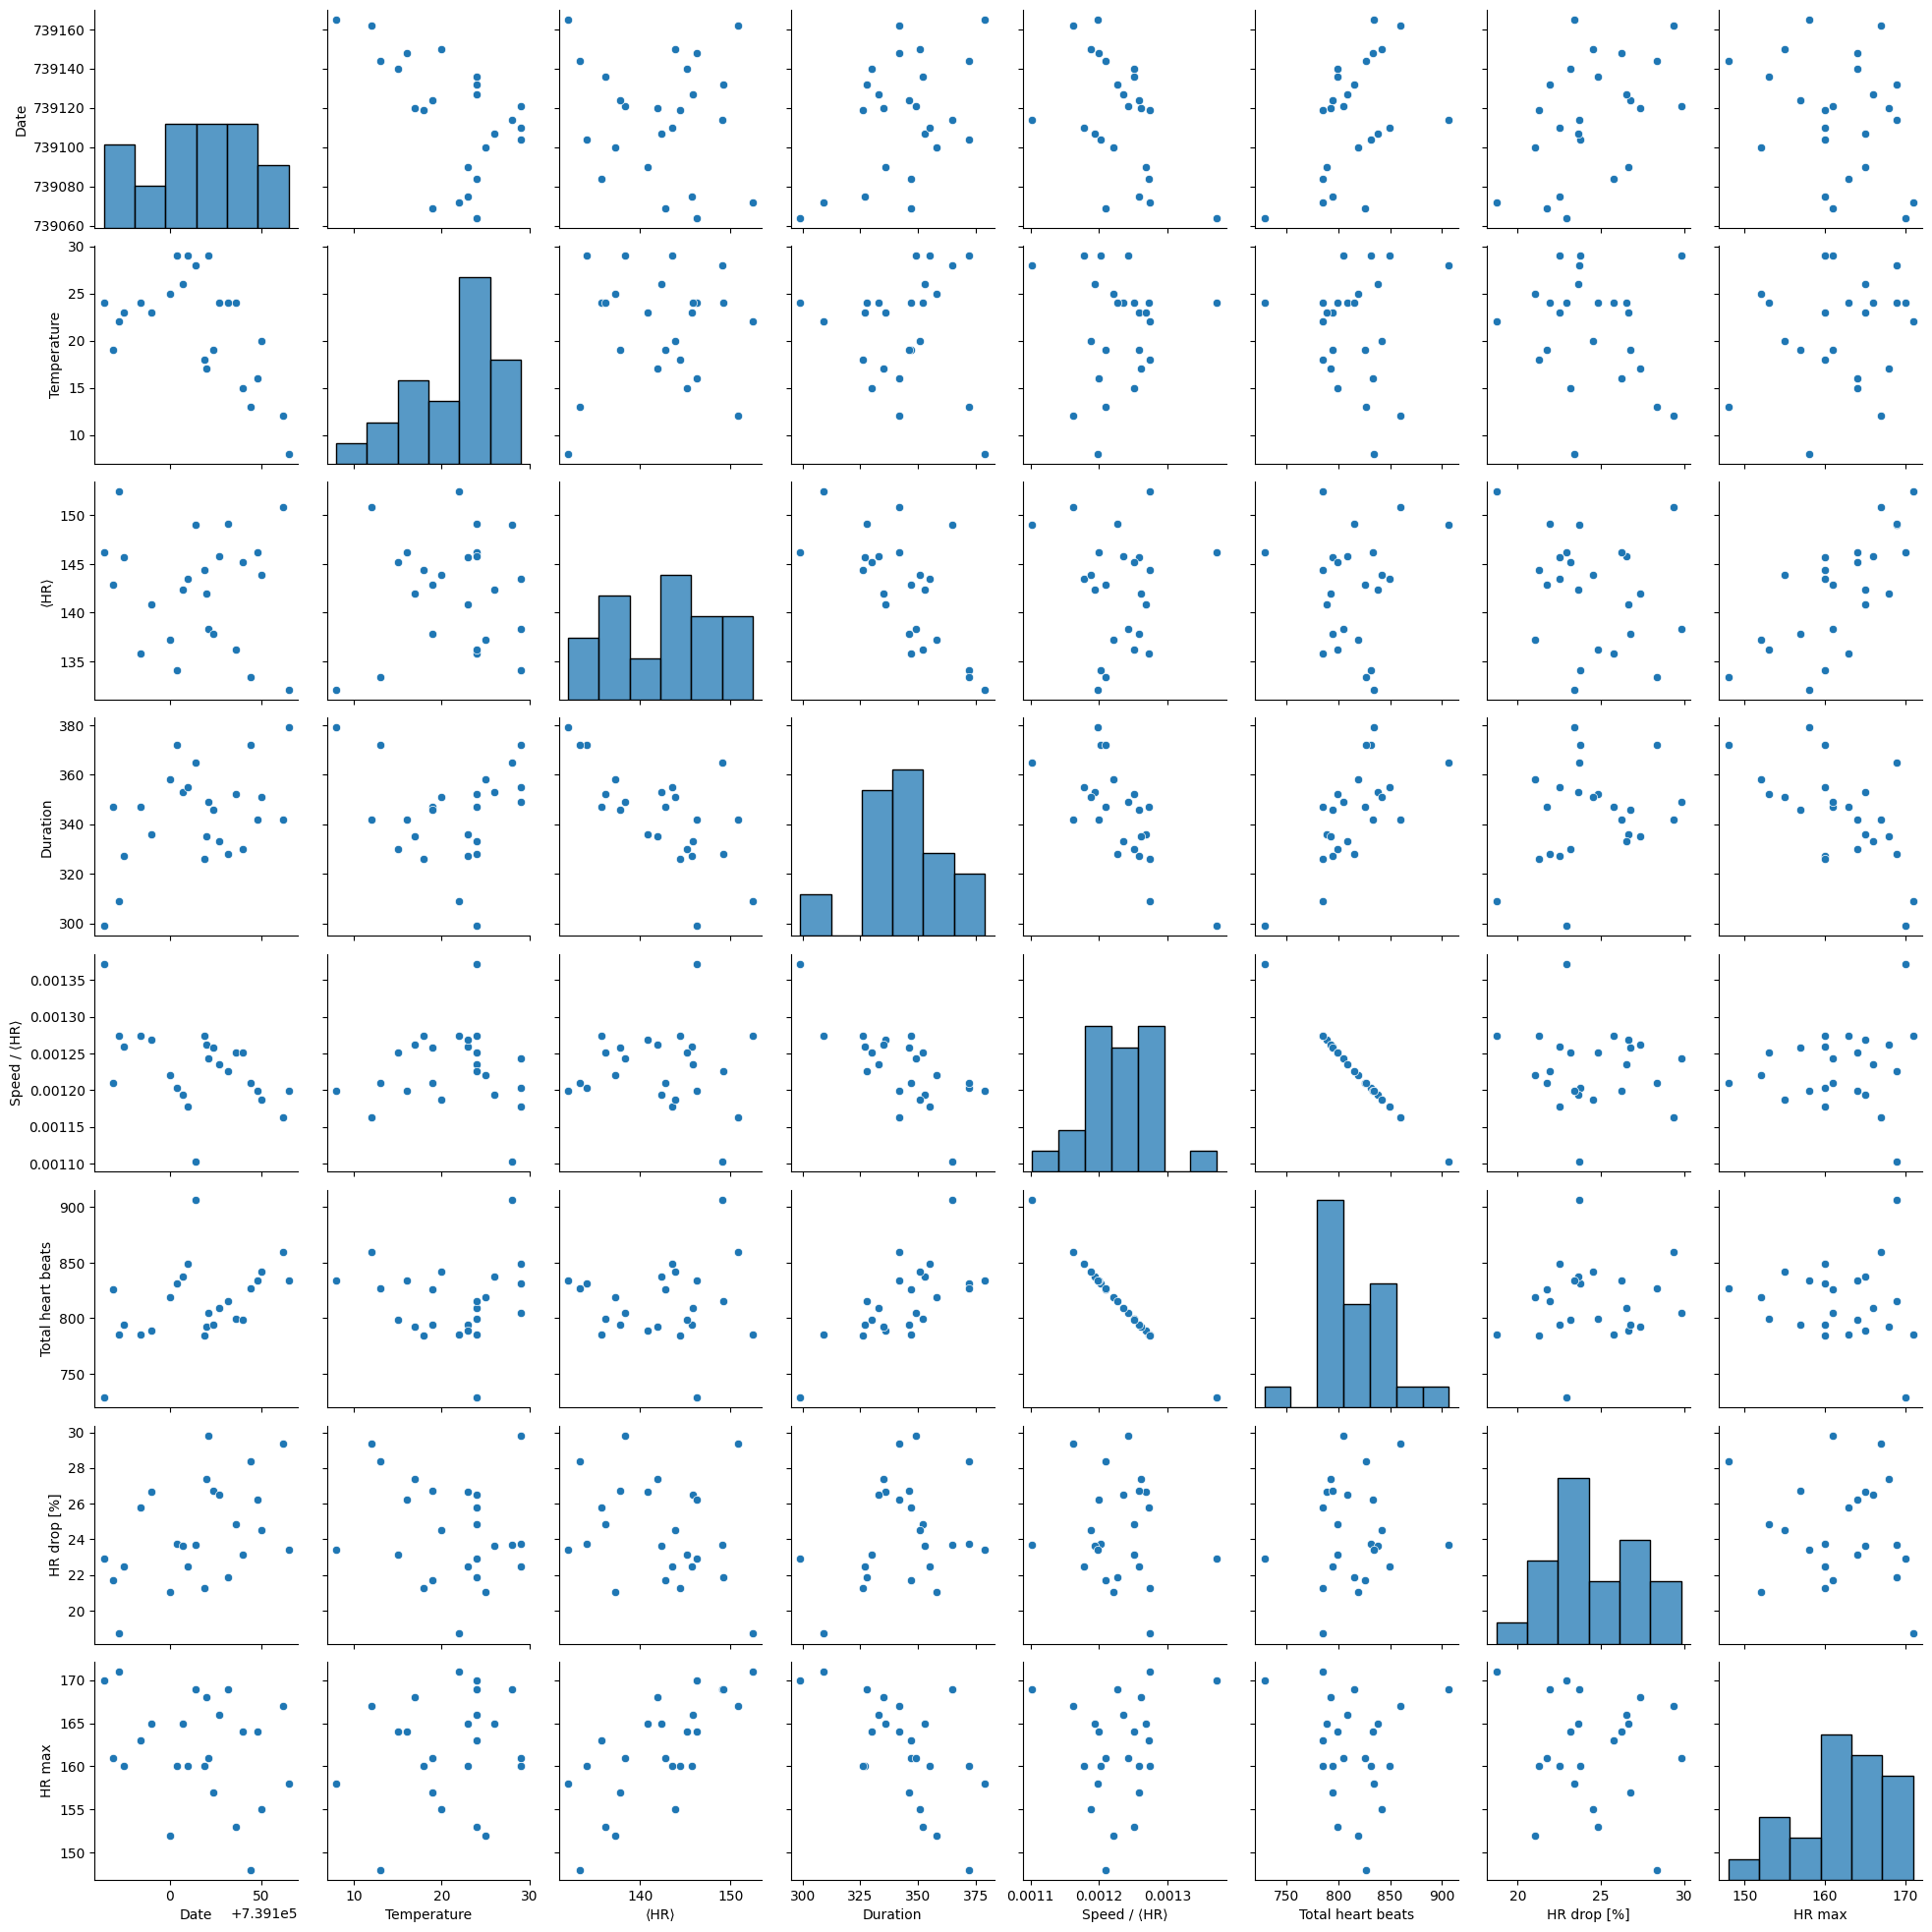

In [6]:
def analyse(track):
    flat_stretch = track.query("location == 'flat stretch'")
    duration = flat_stretch["Time"].max() - flat_stretch["Time"].min()
    downhill = track.query("location == 'downhill'")
    assert pd.to_timedelta("70s") < downhill["Time"].iloc[-1] - downhill["Time"].iloc[0]
    downhill = downhill.loc[
        downhill["Time"] < (downhill["Time"].iloc[0] + pd.to_timedelta("70s"))
    ]
    return pd.Series(
        {
            # https://cyclingpowerpedal.com/post/6-factors-that-affect-heart-rate-and-power-correlation/
            "Temperature": weather.loc[flat_stretch.Time.mean().round("h"), "temp"],
            "⟨HR⟩": flat_stretch["Heart rate"].mean(),
            "Duration": duration / pd.to_timedelta("1sec"),
            # https://runalyze.com/tools/effective-vo2max
            "Speed / ⟨HR⟩": pd.to_timedelta("1min")
            / duration
            / flat_stretch["Heart rate"].mean(),
            # https://fellrnr.com/wiki/Relative_Running_Economy
            "Total heart beats": (
                flat_stretch["Time"].diff()
                / pd.to_timedelta("1min")
                * flat_stretch["Heart rate"]
            ).sum(),
            # https://pezcyclingnews.com/latestnews/toolbox-heart-rate-recovery/
            "HR drop [%]": 100
            * (downhill["Heart rate"].max() - downhill["Heart rate"].min())
            / downhill["Heart rate"].max(),
            "HR max": downhill["Heart rate"].max(),
        }
    )


analysis = tracks.groupby(tracks["Time"].apply(lambda time: time.toordinal())).apply(
    analyse
)
analysis.index.name = "Date"

sns.pairplot(analysis.reset_index())
plt.show()

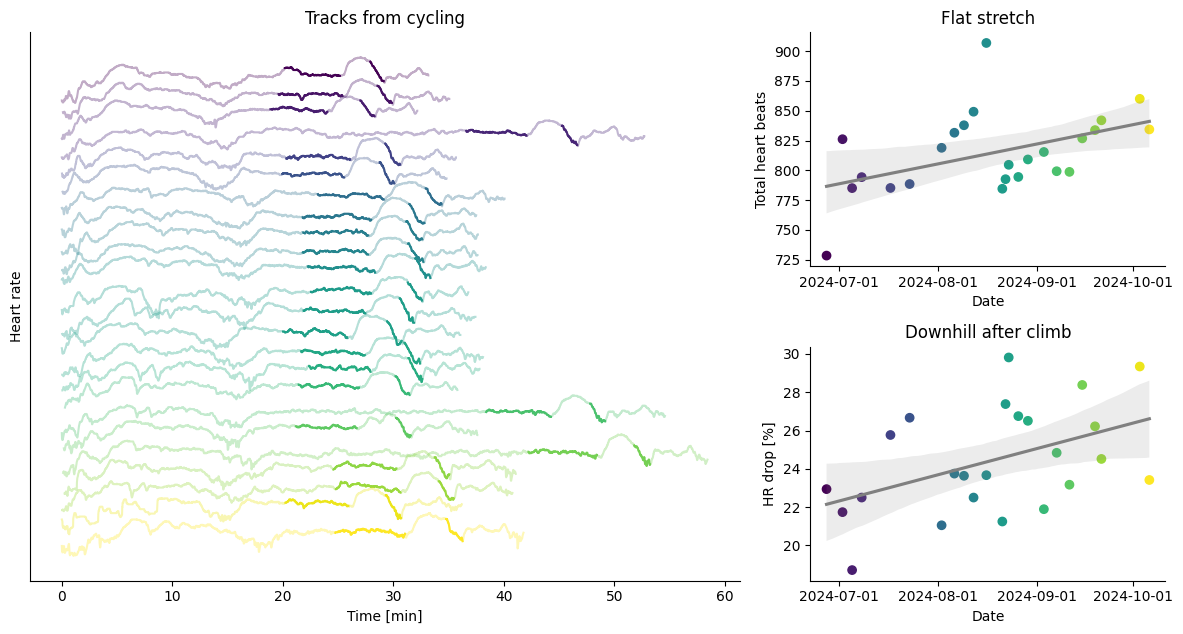

In [7]:
fig, axd = plt.subplot_mosaic(
    [["tracks", "ratio"], ["tracks", "drop"]],
    figsize=(12, 6.44),
    gridspec_kw={"width_ratios": [2, 1]},
)

colors = plt.cm.viridis(
    (analysis.index - analysis.index.min())
    / (analysis.index.max() - analysis.index.min())
)

axd["tracks"].set_title("Tracks from cycling")
for i, ((_, track), color) in enumerate(
    zip(tracks.groupby(tracks["Time"].dt.date), colors)
):
    offset = i * 40
    start = track["Time"].min()
    track["Time"] = (track["Time"] - start) / pd.to_timedelta("1min")
    axd["tracks"].plot(
        track["Time"],
        track["Heart rate"] - offset,
        color=color,
        alpha=0.33,
    )
    for location in track["location"].dropna().unique():
        axd["tracks"].plot(
            track.query(f"location == '{location}'")["Time"],
            track.query(f"location == '{location}'")["Heart rate"] - offset,
            color=color,
        )

axd["tracks"].set_xlabel("Time [min]")
axd["tracks"].set_ylabel("Heart rate")
axd["tracks"].set_yticks([])

axd["ratio"].set_title("Flat stretch")
sns.regplot(
    data=analysis,
    x=analysis.index,
    y="Total heart beats",
    color="0.5",
    ax=axd["ratio"],
    scatter_kws={"color": colors},
)
axd["ratio"].sharex(axd["drop"])

axd["drop"].set_title("Downhill after climb")
sns.regplot(
    data=analysis,
    x=analysis.index,
    y="HR drop [%]",
    color="0.5",
    ax=axd["drop"],
    scatter_kws={"color": colors},
)
dates = ["2024-07-01", "2024-08-01", "2024-09-01", "2024-10-01"]
axd["drop"].set_xticks(
    [datetime.fromisoformat(date).toordinal() for date in dates], dates
)

sns.despine()
plt.tight_layout()
plt.savefig("cycling.png")
plt.show()

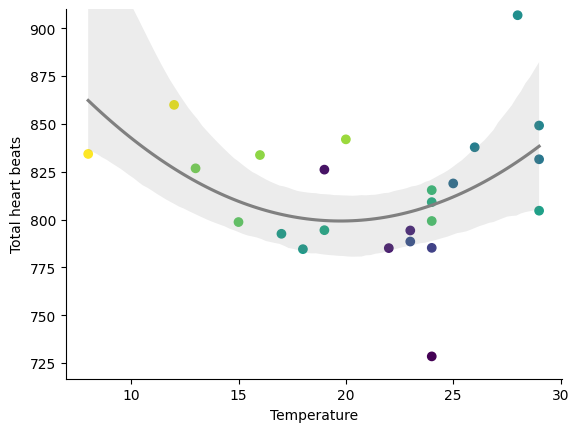

In [8]:
sns.regplot(
    data=analysis,
    x="Temperature",
    y="Total heart beats",
    color="0.5",
    scatter_kws={"color": colors},
    order=2,
)
sns.despine()
plt.ylim(top=910)
plt.show()